# Demo using a trained CVAE model
The goal here is to use a trained CVAE model with new data to create synthetic ensemble members.

# Libraries

In [1]:
# imports
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import os, json
import netCDF4
import cartopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter as gf

from tensorflow import keras
from keras import layers
import cProfile   # For eager execution, https://www.tensorflow.org/guide/eager
from sklearn.model_selection import train_test_split

from scripts.cvae import Sampling, build_encoder, calculate_final_shape, calculate_output_paddings
from scripts.cvae import build_decoder, VAE, plot_latent_space, plot_images

from scripts.get_data import download_file
from scripts.get_data import convert_file
from scripts.get_data import subset_file
from scripts.get_data import remove_data # removes all data

2024-07-29 21:04:16.318682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 21:04:16.318745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 21:04:16.320453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 21:04:16.326930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_154131/3654517447.p

In [2]:
# data loading
def load_data(data_dir):      
    files = [f for f in os.listdir(data_dir)] # if ('subset' in f and 'tmp' not in f)]
    
    all_data = ((np.expand_dims(
        np.concatenate(
            [netCDF4.Dataset(data_dir + converted_file)['msl'][:] for converted_file in files]
        ),
        -1
    ).astype("float32") - 85000) / (110000 - 85000)).astype("float16")
    
    return all_data

In [11]:
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.16.2
GPU is available


# Load and preprocess the input data
The standard way of manipulating arrays in Conv2D layers in TF is to use arrays in the shape:
`batch_size,  height, width, channels = data.shape`
In our case, the the `batch_size` is the number of image frames (i.e. separate samples or rows in a `.csv` file), the `height` and `width` define the size of the image frame in number of pixels, and the `channels` are the number of layers in the frames.  Typically, channels are color layers (e.g. RGB or CMYK) but in our case, we could use different metereological variables.  However, for this first experiment, **we only need one channel** because we're only going to use sea level pressure (SLP).

The code for loading GEFS `.grib` files and making an initial plot is from [Victor Gensini's example](https://github.com/vgensini/gefs_v12_example/blob/master/GEFS_v12_eample.ipynb) posted on the GEFS Open Data Registry landing page.

In [3]:
data_pdir = "./gefs_data"
data_dir = "./gefs_data/converted/"
model_dir = './model_dir'

In [4]:
# example parameters
ex_year = "2018"
ex_month = "01"
ex_day = "01"
ex_ensemble = "c00"

In [5]:
# example for getting and converting files 
download_file(ex_year, ex_month, ex_day, ex_ensemble, data_pdir)
convert_file(ex_year, ex_month, ex_day, ex_ensemble, data_dir)
slp = load_data(data_dir)

In [6]:
# look at data structure
print(np.shape(slp))

(80, 721, 1440, 1)


In [7]:
# grid point locations
lons = np.loadtxt('coordinates/lon.x')
lats = np.loadtxt('coordinates/lat.y')

x, y = np.meshgrid(lons,lats)

np.shape(x)

(721, 1440)

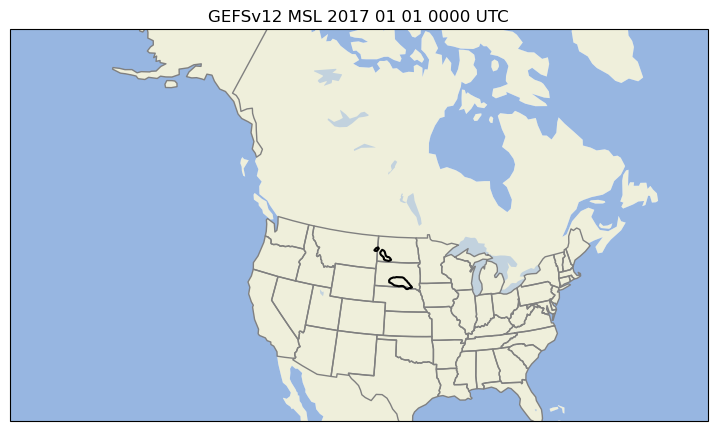

In [8]:
# example for plot
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection = cartopy.crs.LambertConformal())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, edgecolor='grey')
plt.contour(x,y,np.squeeze(slp[0,:,:,0])*120000/100,
             transform = cartopy.crs.PlateCarree(),
             levels=[970,975,980,985,990,995,1000,1005,1010,1015,1020,1025,1030,1035,1040,1045,1050,1055,1060],colors='k')
plt.title('GEFSv12 MSL 2017 01 01 0000 UTC')
#ax.set_extent([-120, -73, 23, 50])
ax.set_extent([-150, -60, 20, 65])
#plt.colorbar()
plt.show()

# Load ML model

In [9]:
# key CVAE definition parameters
latent_dim = 2
n_conv_layers = 4
stride = 2
kernel_size = 3
batch_size, height, width, channels = slp.shape

encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer='rmsprop')
vae.load_weights(os.path.join('model_dir', 'vae.weights.h5'))

2024-07-29 21:04:26.954295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-29 21:04:27.001634: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-29 21:04:27.005261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 721, 1440, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 79, 143,   │      3,904 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 15, 15,    │     92,224 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 14400)     │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │    230,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 326,612 (1.25 MB)

 Trainable params: 326,612 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14400)          │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 75, 135, 64)    │       184,384 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 675, 1350, 32)  │       247,840 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 675, 1350, 1)   │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,713 (1.81 MB)

 Trainable params: 475,713 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

None


/home/lobielodan/pw/.miniconda3c/envs/cvae_env/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
z_mean, z_log_var, z = vae.encoder(slp.astype('float16'))
sample_output_images = vae.decoder(z)

2024-07-29 21:04:28.443990: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-07-29 21:04:29.384748: W tensorflow/core/kernels/gpu_utils.cc:68] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-07-29 21:05:07.838587: W external/local_tsl/tsl/framework/bfc_allocator.cc:487] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.69GiB (rounded to 9331200000)requested by op Conv2DBackpropInput
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-29 21:05:07.839063: I external/local_tsl/tsl/framework/bfc_allocator.cc:1044] BFCAllocator dump for GPU_0_bfc
2024-07-29 21:05:07.839094: I external/local_tsl/tsl/framework/b

ResourceExhaustedError: Exception encountered when calling Conv2DTranspose.call().

[1m{{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[80,675,1350,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput][0m

Arguments received by Conv2DTranspose.call():
  • inputs=tf.Tensor(shape=(80, 75, 135, 64), dtype=float32)

# Encode, perturb, and decode

In [ ]:
print(tf.executing_eagerly())
#tf.compat.v1.enable_eager_execution()

# Plot setup
#fig, ax = plt.subplots(figsize=(9,6))
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection = cartopy.crs.LambertConformal())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, edgecolor='grey')

# Plot each one
for i, image in enumerate(sample_output_images):
    if i == 0 :
        print('Filtering...')
        filtered = gf(np.squeeze(image)*120000/100, [3,3], mode='constant')
        print(np.mean(filtered))
        print(np.std(filtered))
        #plt.pcolor(x,y,np.squeeze(image)*120000/100,shading='auto')
            #transform = cartopy.crs.PlateCarree(),shading='auto')
        print('Contour plotting...')
        plt.contour(x,y,filtered,
            transform = cartopy.crs.PlateCarree(),
            levels=[980,990,1000,1010,1015,1020,1025,1030,1035,1040,1045,1050],colors='r',linewidths=1)   

# Plot original
print('Filtering...')
filtered = gf(np.squeeze(slp[0,:,:,0])*120000/100, [3,3], mode='constant')
print('Contour plotting...')
plt.contour(x,y,filtered,
             transform = cartopy.crs.PlateCarree(),
             levels=[980,990,1000,1010,1015,1020,1025,1030,1035,1040,1045,1050],colors='k',linewidths=2)

#plt.title('GEFSv12 Re-forecast SLP 990hPa 2018 01 10 0000 UTC Cycle')
#ax.set_extent([-120, -73, 23, 50])
ax.set_extent([-150, -60, 20, 65])
#ax.set_xlim([-150,-60])
#ax.set_ylim([20,65])
#plt.colorbar()
plt.show()

# Perturb current state

In [ ]:
perturbed_images_high = vae.decoder(z_mean + z_log_var)
perturbed_images_low = vae.decoder(z_mean - z_log_var)

print(tf.executing_eagerly())
#tf.compat.v1.enable_eager_execution()

# Plot setup
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection = cartopy.crs.LambertConformal())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, edgecolor='grey')

# Plot each one
for i, image in enumerate(perturbed_images_high):
    if i == 0 :
        print('Filtering...')
        filtered = gf(np.squeeze(image)*120000/100, [3,3], mode='constant')
        print('Contour plotting...')
        plt.contour(x,y,filtered,
            transform = cartopy.crs.PlateCarree(),
            levels=[980,990,1000,1010,1015,1020,1025,1030,1035,1040,1045,1050],colors='r',linewidths=1)   

# Plot each one
for i, image in enumerate(perturbed_images_low):
    if i == 0 :
        print('Filtering...')
        filtered = gf(np.squeeze(image)*120000/100, [3,3], mode='constant')
        print('Contour plotting...')
        plt.contour(x,y,filtered,
            transform = cartopy.crs.PlateCarree(),
            levels=[980,990,1000,1010,1015,1020,1025,1030,1035,1040,1045,1050],colors='b',linewidths=1)   
    
# Plot original
plt.contour(x,y,np.squeeze(slp[0,:,:,0])*120000/100,
             transform = cartopy.crs.PlateCarree(),
             levels=[980,990,1000,1010,1015,1020,1025,1030,1035,1040,1045,1050],colors='k',linewidths=2)

plt.title('GEFSv12 Re-forecast SLP 990hPa 2018 01 10 0000 UTC Cycle')
#ax.set_extent([-120, -73, 23, 50])
ax.set_extent([-150, -60, 20, 65])
#plt.colorbar()
plt.show()

# Generate totally random weather maps

In [ ]:
codings = tf.random.normal(shape = [12, latent_dim])
images = vae.decoder(codings).numpy()

# Plot setup
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection = cartopy.crs.LambertConformal())
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAKES, alpha = 0.5)
ax.add_feature(cartopy.feature.STATES, edgecolor='grey')

# Plot each one
for i, image in enumerate(images):
    print('Filtering...')
    filtered = gf(np.squeeze(image)*120000/100, [5,5], mode='constant')
    plt.contour(x,y,filtered,
        transform = cartopy.crs.PlateCarree(),
        levels=[970,980,990,1000,1010,1015,1020,1025,1030,1040,1050,1060],colors='k',linewidths=1)
        
#plt.title('Random MSL pressure maps from ML model trained with GEFSv12 Re-forecast 2018-2019')
#ax.set_extent([-120, -73, 23, 50])
ax.set_extent([-150, -60, 20, 65])
#plt.colorbar()
plt.show()

In [ ]:
print(latent_dim)